In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

df =pd.read_csv("/content/dados.csv")


In [62]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150941 entries, 0 to 150940
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   NomeVariedade           150941 non-null  object 
 1   SiglaAmbienteProducao   150940 non-null  object 
 2   AnoSafra                150941 non-null  int64  
 3   NomeTpColheita          150941 non-null  object 
 4   EpocaCorte              150935 non-null  float64
 5   EpocaInicioCrescimento  143773 non-null  float64
 6   CanaDeAnoMeio           150101 non-null  float64
 7   CanaIrrigada            149566 non-null  float64
 8   Corte                   150936 non-null  float64
 9   Bizada                  150941 non-null  int64  
 10  Queimada                150790 non-null  float64
 11  AplicVinhaca            150941 non-null  int64  
 12  AplicTortaFiltro        150941 non-null  int64  
 13  LiberacaoCotesia        150941 non-null  int64  
 14  AplicAdubacao       

In [63]:
df=df.dropna() #removendo linhas nulas 

In [64]:
df.isna().sum() #vericaocao de linhas nulas

NomeVariedade             0
SiglaAmbienteProducao     0
AnoSafra                  0
NomeTpColheita            0
EpocaCorte                0
EpocaInicioCrescimento    0
CanaDeAnoMeio             0
CanaIrrigada              0
Corte                     0
Bizada                    0
Queimada                  0
AplicVinhaca              0
AplicTortaFiltro          0
LiberacaoCotesia          0
AplicAdubacao             0
Meiosi                    0
TCH                       0
dtype: int64

In [65]:
#convertendo as coluna de dados categoriricos
#removendo a coluna TCH
categorical_columns = df.columns.to_list()
categorical_columns.remove("TCH")
df = pd.get_dummies(df, columns=categorical_columns)
print(df.shape)

(142570, 275)


In [66]:
#Separando dados de treinamento e teste
train_dataset = df.sample(frac=0.8,random_state=0)#80% trinamento
test_dataset = df.drop(train_dataset.index)#20% teste

In [67]:
#Separe o valor alvo(labels), das features. 
#Esta label é o valor no qual o modelo é treinado para prever.
train_labels = train_dataset.pop('TCH')
test_labels = test_dataset.pop('TCH')


In [68]:
train_stats=train_labels.describe()

In [69]:
#Normalize os dadosé o que nós usaremos para treinar o modelo.
#(subtrai a media do valor e divide pelo desvio padrao)
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_labels)
normed_test_data = norm(test_labels)

In [70]:
#construindo o modelo.  usaremos o modelo Sequential com duas camadas densely connected
# e a camada de saída que retorna um único valor contínuo. Os passos de construção 
# do modelo são agrupados em uma função, build_model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [71]:
# inicializacao do modelo
model = build_model()

In [72]:
#checando a arquitetura do modelo
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                17600     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintarPonto(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# O paramêtro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# realiza o treinamento
history = model.fit(
  train_dataset, normed_train_data,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop,PrintarPonto()])


............................

In [74]:
#verifica o historico do treinamento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
23,0.492184,0.485236,0.492184,0.539057,0.504271,0.539057,23
24,0.491070,0.484258,0.491070,0.545732,0.515041,0.545732,24
25,0.490844,0.484738,0.490844,0.540239,0.504383,0.540239,25
26,0.489941,0.483327,0.489941,0.529684,0.498727,0.529684,26
27,0.490628,0.484661,0.490628,0.530805,0.498657,0.530805,27


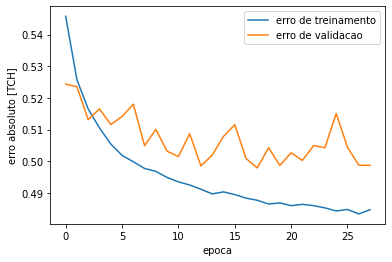

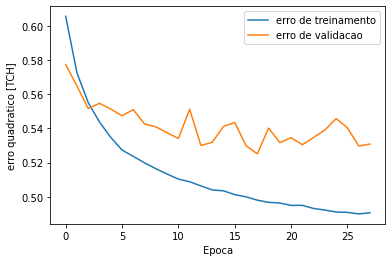

In [75]:
#plota as metrica de treinamentos
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('epoca')
  plt.ylabel('erro absoluto [TCH]')
  plt.plot(hist['epoch'], hist['mae'],
           label='erro de treinamento')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'erro de validacao')
  
  plt.legend()

  plt.figure()
  plt.xlabel('Epoca')
  plt.ylabel('erro quadratico [TCH]')
  plt.plot(hist['epoch'], hist['mse'],
           label='erro de treinamento')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'erro de validacao')
  
  plt.legend()
  plt.show()


plot_history(history)

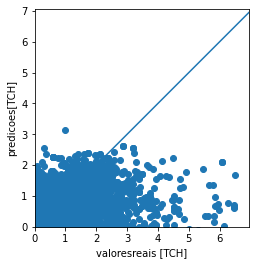

In [76]:
#faca predicoes prevejamos os valores TCH usando o conjunto de teste.
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(normed_test_data, test_predictions)
plt.xlabel('valoresreais [TCH]')
plt.ylabel('predicoes[TCH]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [77]:
# funcao de desnormalizacao dos dados 
#(multiplica o valor pelo o desvio padrao e soma a media )
def desnorm(x):
  return train_stats['mean']+ (x*train_stats['std'])
desnorme=desnorm(test_predictions)

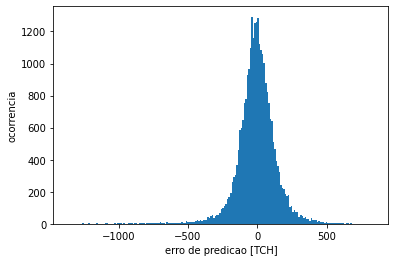

In [78]:
#histograma de erro do modelo
error = desnorme - test_labels
plt.hist(error, bins = 200)
plt.xlabel("erro de predicao [TCH]")
_ = plt.ylabel("ocorrencia")